In [2]:
%matplotlib notebook 
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('/home/dana_z/ssd_2TB/6OHDA')

import numpy as np
import scipy as sci
from sklearn import svm

from scipy import signal
from matplotlib import pyplot as plt
from matplotlib import gridspec

import sys
import h5py
from IO import *
from utils import *
from plotUtils import *
from ColorSchems import colorPallet as CP

import pptx
from pptx import Presentation 
from pptx.util import Inches
from io import BytesIO
import re
import warnings


<b> process lfp data so that every 30s is 1 data point </b>

In [5]:
dataFile = 'Data_6OHDA_H_all.h5';

In [9]:
data = getData(dataFile,['lfp','mvmt'],period ='Pre',day = lambda x: int(x)==0)

cleaning up lfp data
I deleted session: 4539_BaselineA
cleaning up mvmt data


<IPython.core.display.Javascript object>


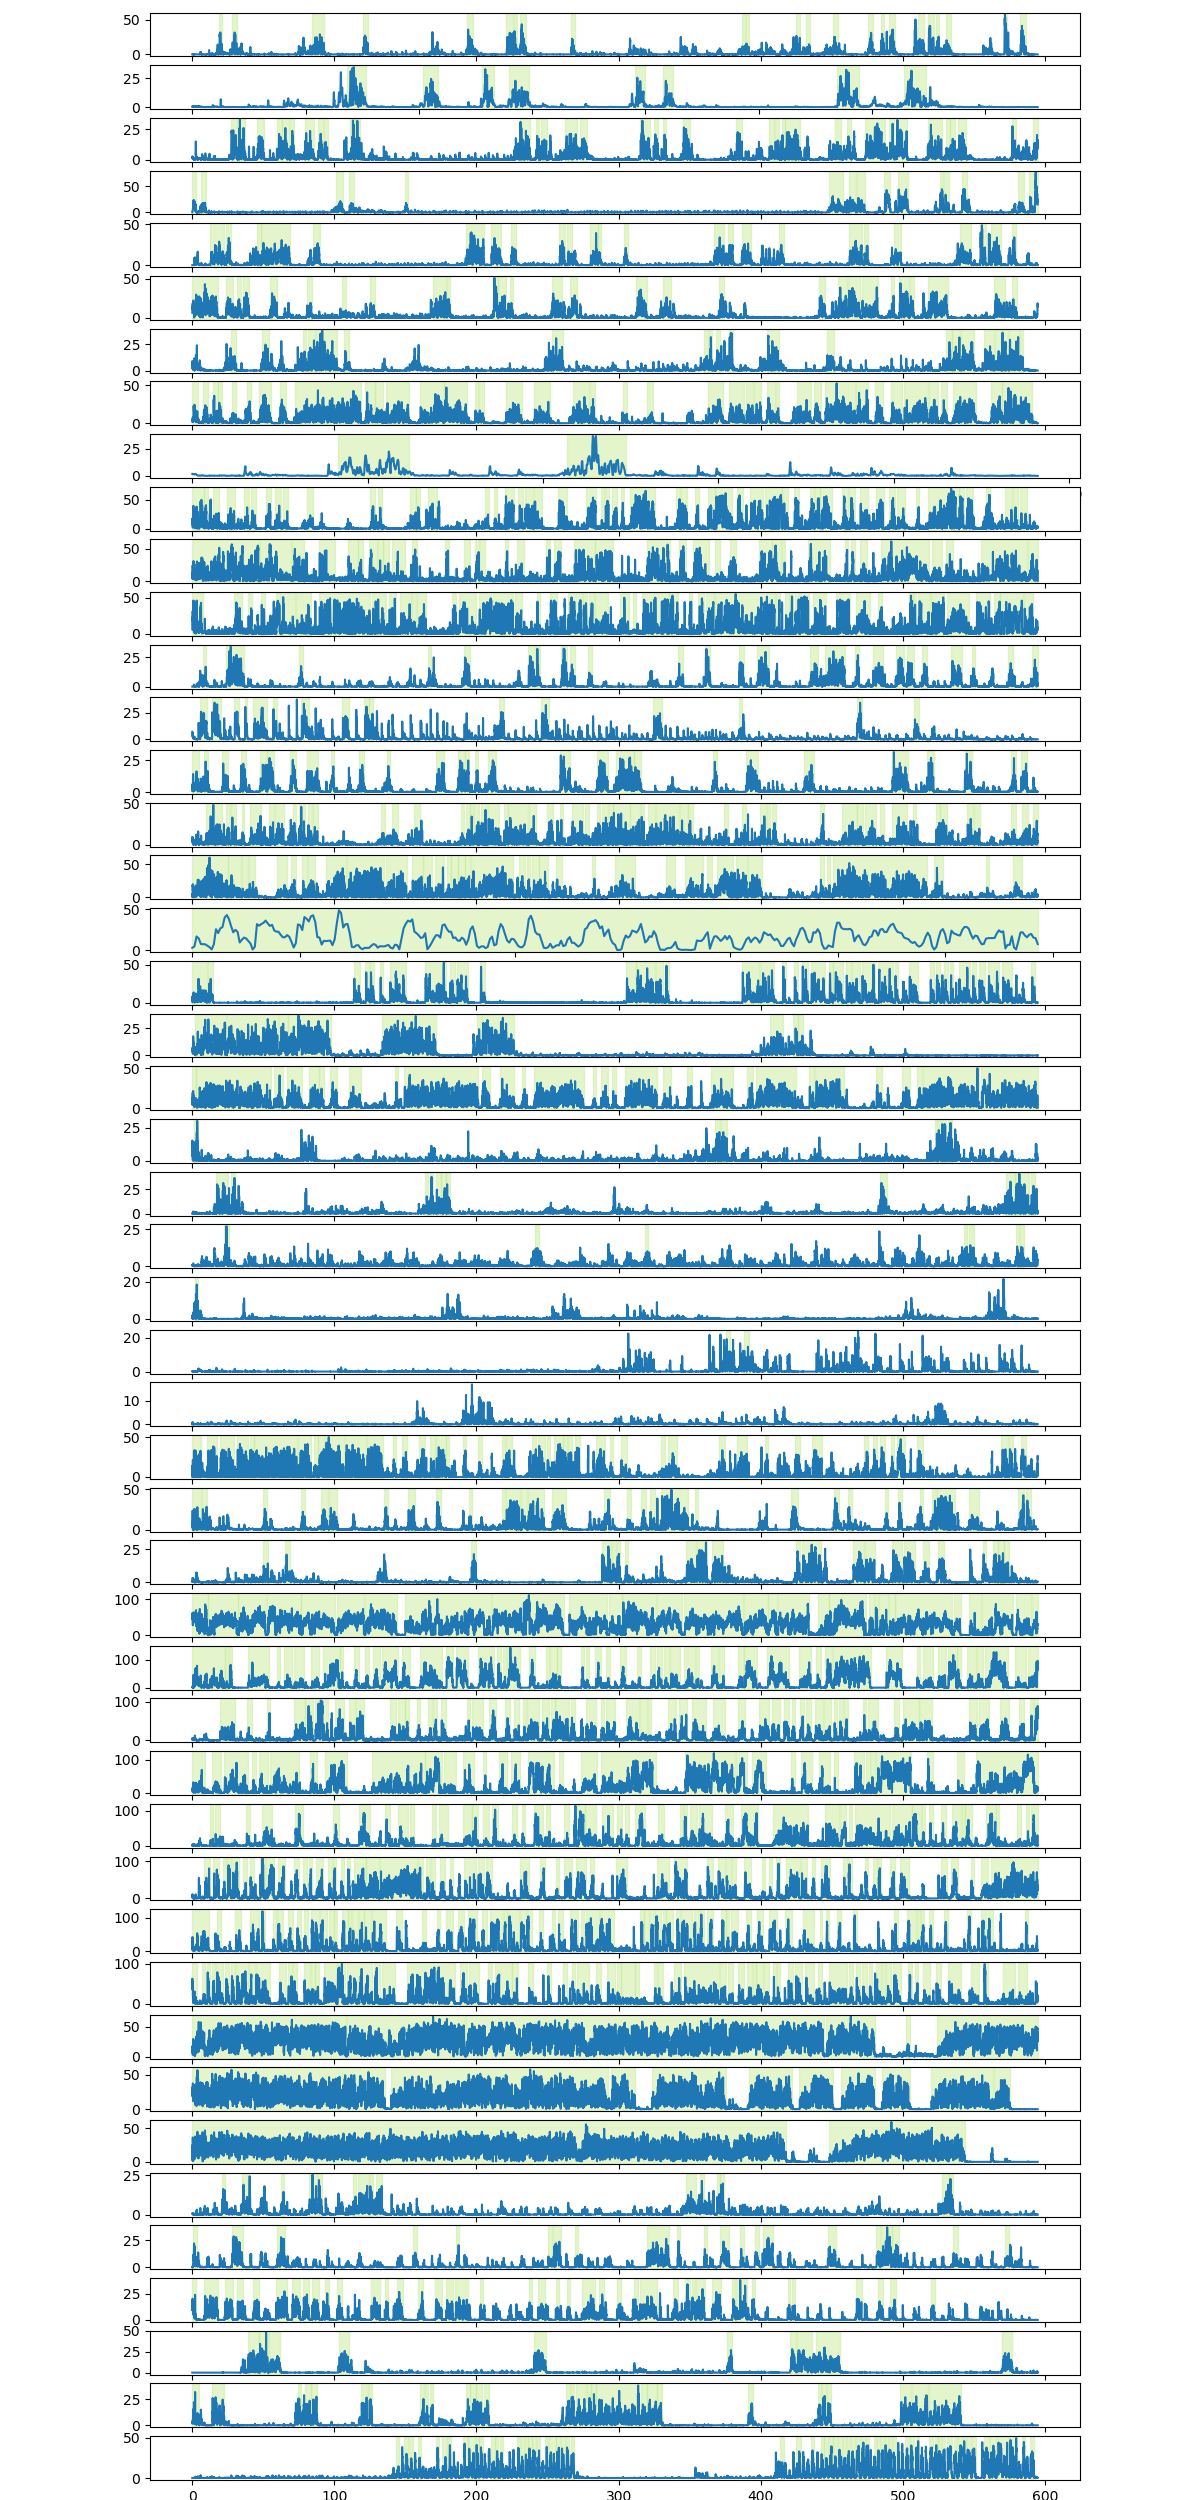

In [11]:
fig, ax = plt.subplots(len(data.keys()),1,figsize=(12, 25),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})
Colors = CP('highLowSpeed')
dt = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 2
dataPoints = int(np.ceil(Tseconds/dt))
th = 3
sessNum = 0
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed']
    dt  = 1/data[s]['mvmt']['Fs'][0]
    
    data[s]['highSpeed'] = HighSpeedPeriods(ax[sessNum],speed.T,dt,th, dataPoints, Colors['high'])
    sessNum = sessNum +1

<IPython.core.display.Javascript object>


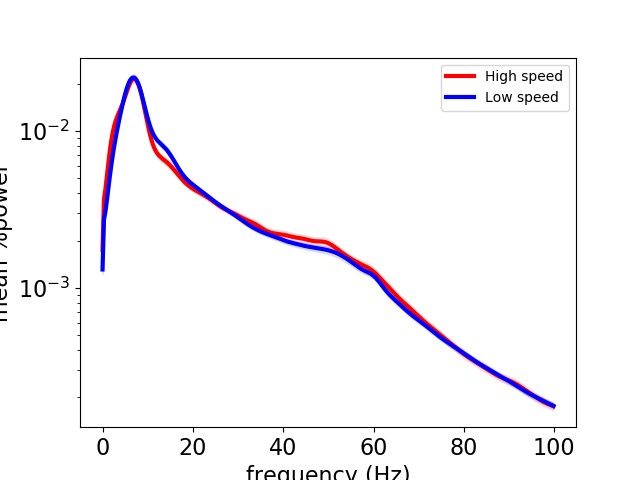

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


In [14]:
fig, ax = plt.subplots(1,1)
numS = len(data.keys())
cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/data['1208_BaselineA']['lfp']['FS'][0]

sNum = 0
phigh = []
plow = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed'].T
    lfp = data[s]['lfp']['lfp'].T[0,:]
    if len(speed)<600:
        numS = numS-1
        continue
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(data[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[data[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[data[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh.append(Power/totPower)    
    phigh.append(PowerHigh/totPowerHigh)
    plow.append(PowerLow/totPoweLow)
phigh = np.array(phigh)
plow = np.array(plow)
Mhigh = np.nanmean(phigh,axis=0)
Mlow = np.nanmean(plow,axis=0)
Stdhigh = np.nanstd(phigh, axis = 0)/np.sqrt(numS)
Stdlow = np.nanstd(plow, axis = 0)/np.sqrt(numS)
ax.semilogy(f[0:cutoff], Mhigh, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], Mlow, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], Mhigh-Stdhigh, Mhigh+Stdhigh,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], Mlow-Stdlow, Mlow+Stdlow,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

<IPython.core.display.Javascript object>


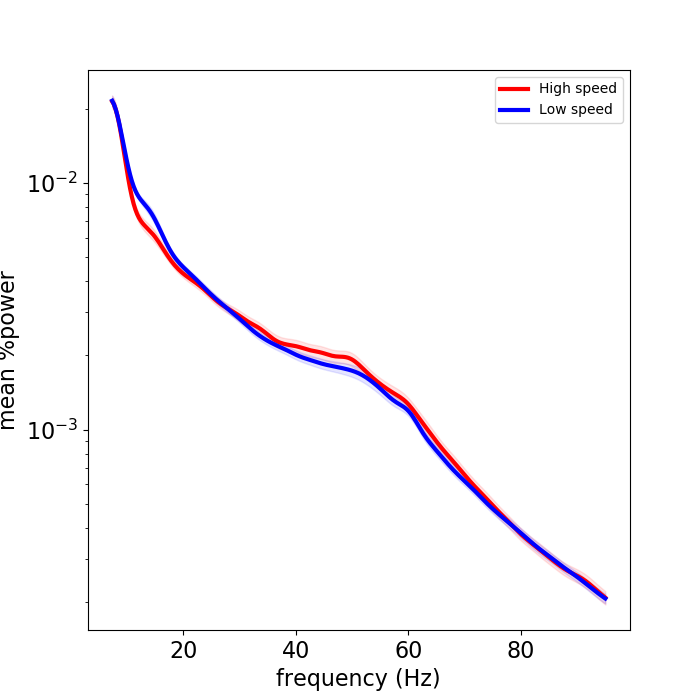

In [49]:
fig, ax = plt.subplots(1,1,figsize=(7, 7),gridspec_kw = {'top':0.9,'bottom':0.1,'wspace':0.1}
                      )
cutoff=300
ax.semilogy(f[23:cutoff], Mhigh[23:cutoff], linewidth=3,color='red', label='High speed')
ax.semilogy(f[23:cutoff], Mlow[23:cutoff], linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[23:cutoff], Mhigh[23:cutoff]-Stdhigh[23:cutoff], Mhigh[23:cutoff]+Stdhigh[23:cutoff],color='red',alpha=0.1)
ax.fill_between(f[23:cutoff], Mlow[23:cutoff]-Stdlow[23:cutoff], Mlow[23:cutoff]+Stdlow[23:cutoff],color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

In [46]:
print(t[23]-t[22])

0.05242879999999994


<IPython.core.display.Javascript object>


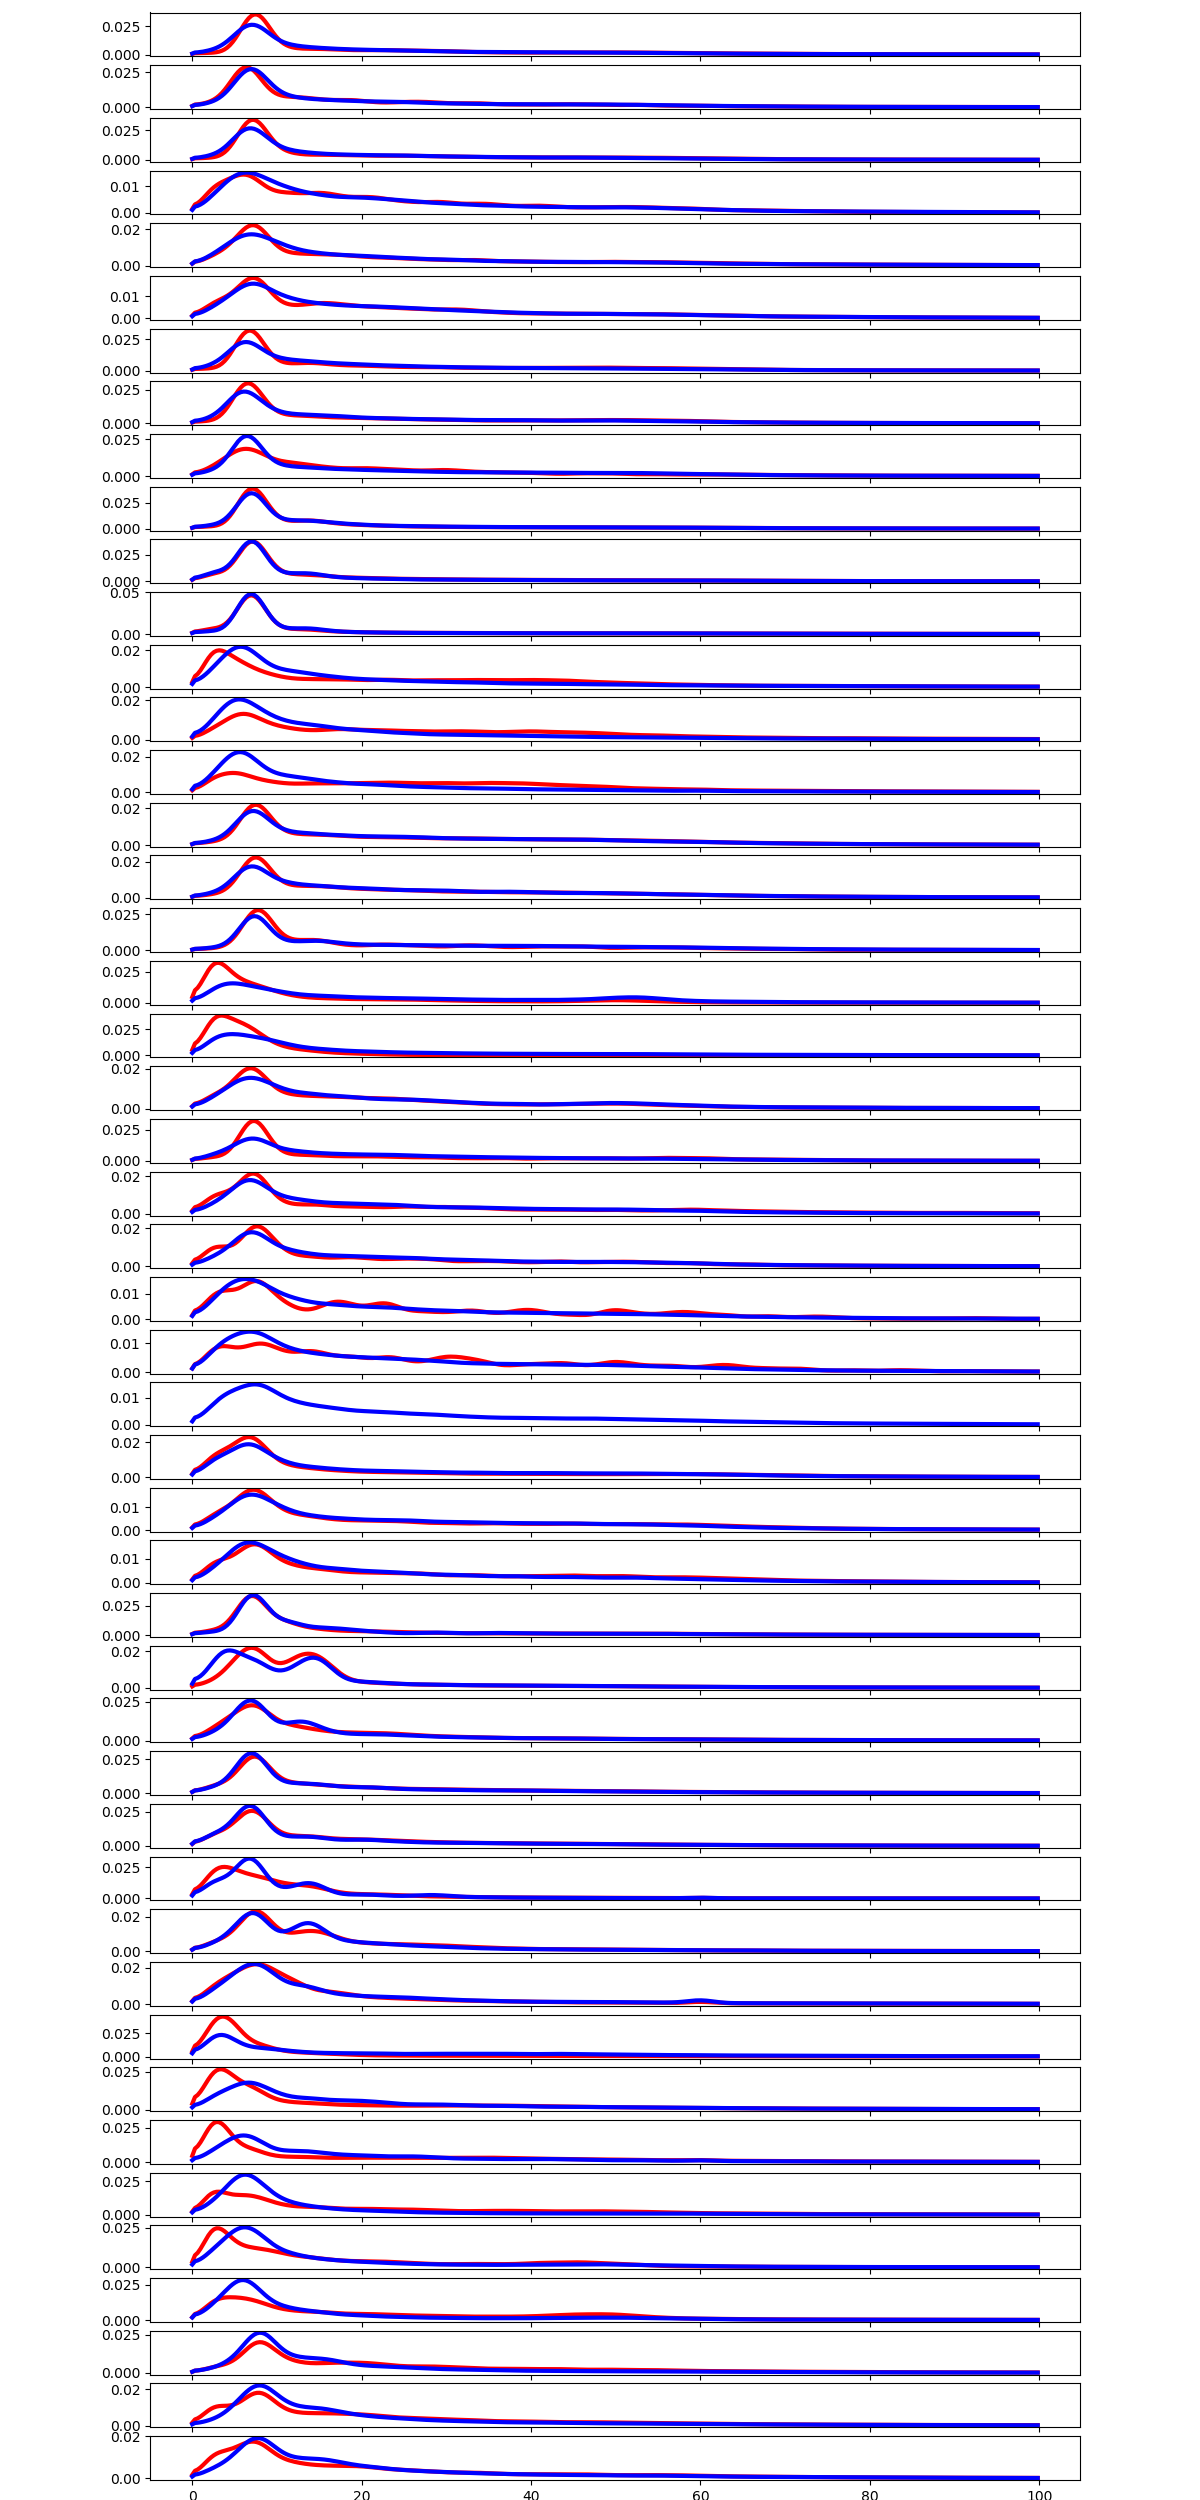

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


In [12]:
fig, ax = plt.subplots(len(data.keys()),1,figsize=(12, 25),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})


cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/data['1208_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/data['1208_BaselineA']['lfp']['FS'][0]

sNum = 0
phigh = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed'].T
    lfp = data[s]['lfp']['lfp'].T[0,:]
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(data[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[data[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[data[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh.append(Power/totPower)    
    phigh = PowerHigh/totPowerHigh
    plow = PowerLow/totPoweLow
#    phigh = np.array(phigh)
#    M = np.nanmean(phigh,axis=0)
#    Std = np.nanstd(phigh, axis = 0)
    ax[sNum].plot(f[0:cutoff], phigh, linewidth=3,color='red')
    ax[sNum].plot(f[0:cutoff], plow, linewidth=3,color='blue')
    sNum = sNum+1 
#    ax[sNum].fill_between(f[0:cutoff], M-Std, M+Std,color='blue',alpha=0.1)

In [51]:
data = getData(dataFile,['lfp','mvmt'],period ='Pre',day = lambda x: int(x)>3)

cleaning up lfp data
I deleted session: 7584_day12
I deleted session: 7584_day30A
I deleted session: 7909_day15A
I deleted session: 7909_day30A
cleaning up mvmt data


<IPython.core.display.Javascript object>


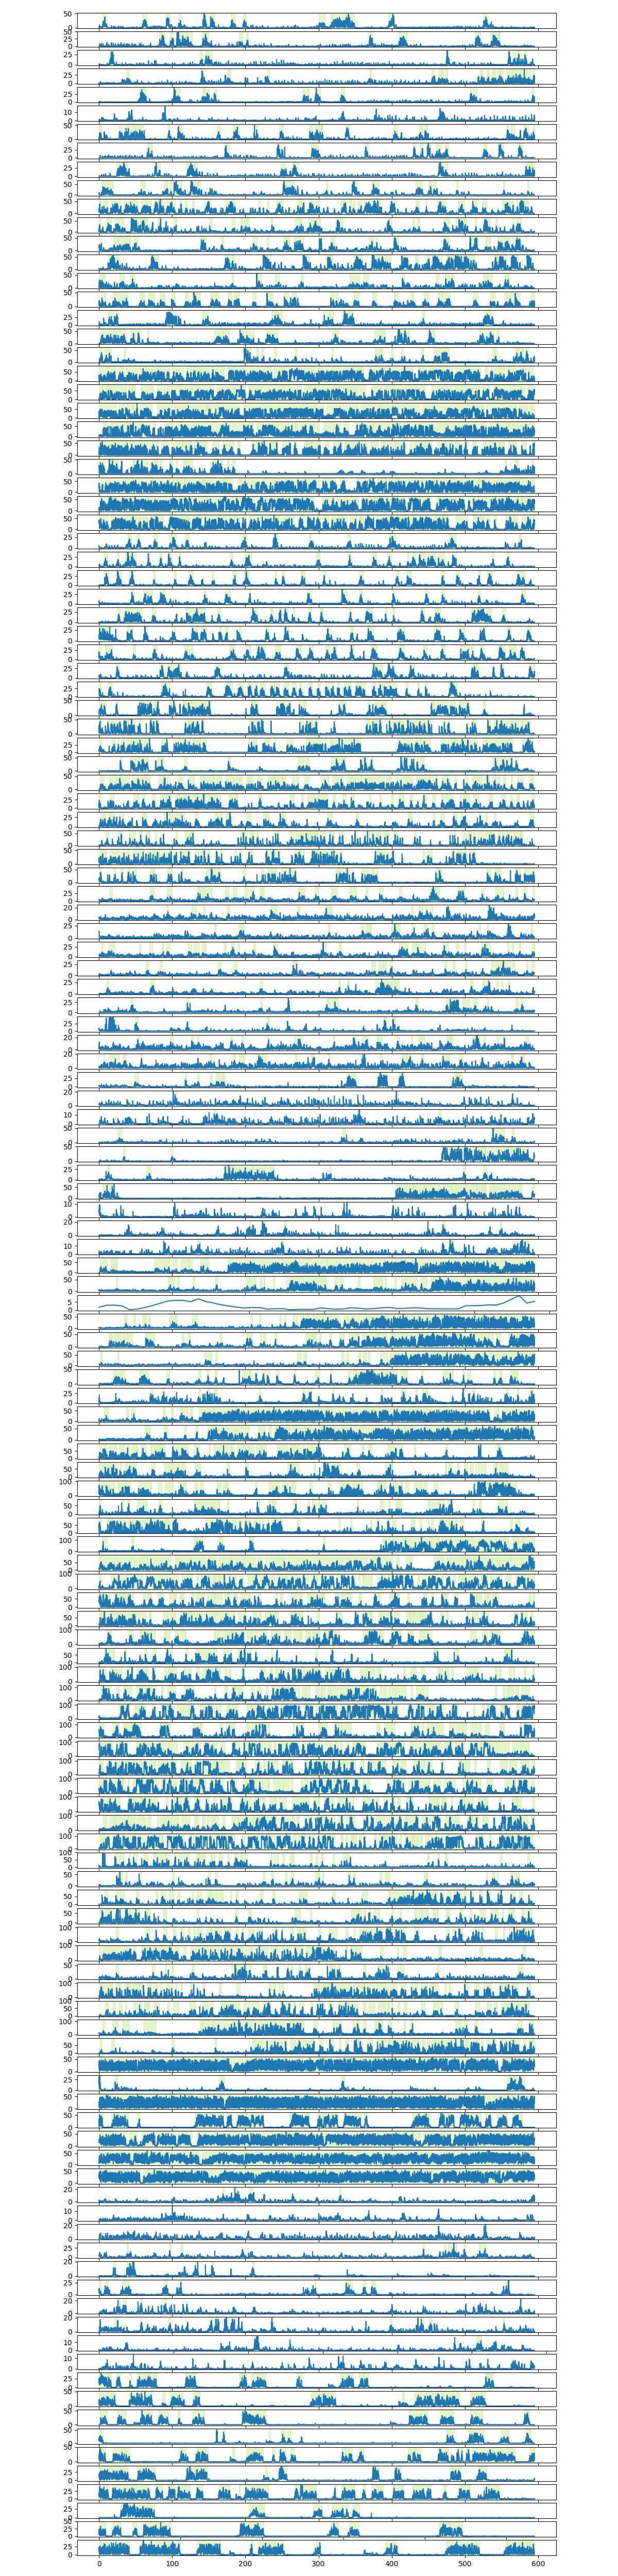

In [52]:
fig, ax = plt.subplots(len(data.keys()),1,figsize=(12, 50),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})
Colors = CP('highLowSpeed')
dt = 1/data['0761_day10']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 2
dataPoints = int(np.ceil(Tseconds/dt))
th = 3
sessNum = 0
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed']
    dt  = 1/data[s]['mvmt']['Fs'][0]
    
    data[s]['highSpeed'] = HighSpeedPeriods(ax[sessNum],speed.T,dt,th, dataPoints, Colors['high'])
    sessNum = sessNum +1

<IPython.core.display.Javascript object>


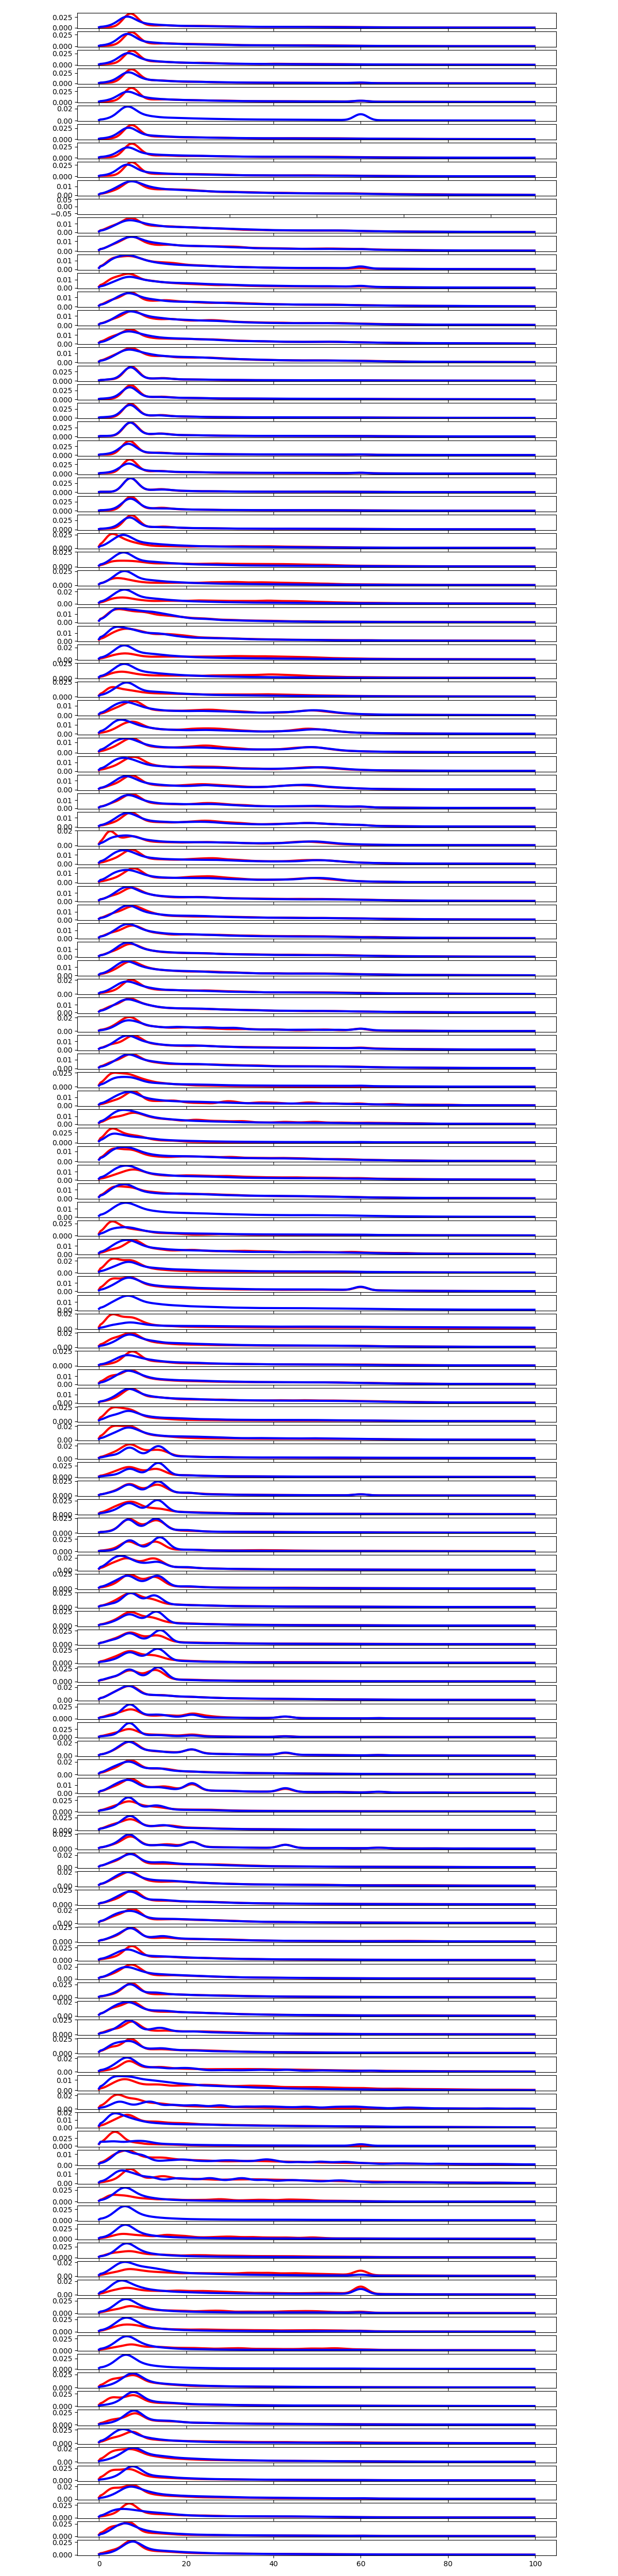

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


In [97]:
fig, ax = plt.subplots(len(data.keys()),1,figsize=(12, 50),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})


cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/data['0761_day10']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/data['0761_day10']['lfp']['FS'][0]

sNum = 0
phigh = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed'].T
    lfp = data[s]['lfp']['lfp'].T[0,:]
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(data[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[data[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[data[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh.append(Power/totPower)    
    phigh = PowerHigh/totPowerHigh
    plow = PowerLow/totPoweLow
#    phigh = np.array(phigh)
#    M = np.nanmean(phigh,axis=0)
#    Std = np.nanstd(phigh, axis = 0)
    ax[sNum].plot(f[0:cutoff], phigh, linewidth=3,color='red')
    ax[sNum].plot(f[0:cutoff], plow, linewidth=3,color='blue')
    sNum = sNum+1 
#    ax[sNum].fill_between(f[0:cutoff], M-Std, M+Std,color='blue',alpha=0.1)

<IPython.core.display.Javascript object>


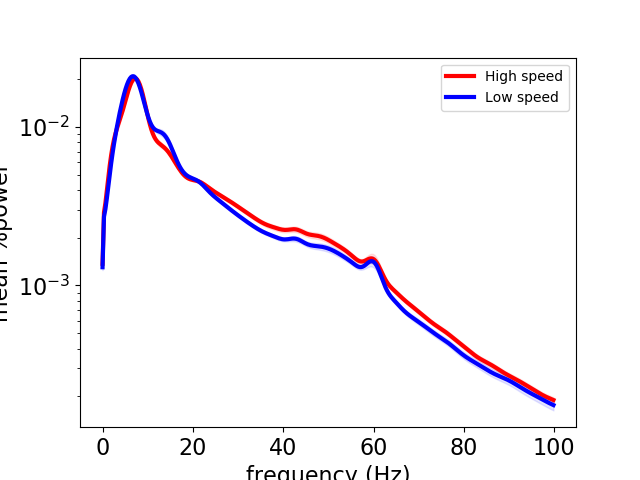

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/home/dana_z/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


In [53]:
fig, ax = plt.subplots(1,1)
numS = len(data.keys())
cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/data['0761_day10']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/data['0761_day10']['lfp']['FS'][0]

sNum = 0
phigh = []
plow = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in data.keys():
    #find movment onset:
    speed = data[s]['mvmt']['speed'].T
    lfp = data[s]['lfp']['lfp'].T[0,:]
    if len(speed)<600:
        numS = numS-1
        continue
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(data[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[data[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[data[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh.append(Power/totPower)    
    phigh.append(PowerHigh/totPowerHigh)
    plow.append(PowerLow/totPoweLow)
phigh = np.array(phigh)
plow = np.array(plow)
Mhigh = np.nanmean(phigh,axis=0)
Mlow = np.nanmean(plow,axis=0)
Stdhigh = np.nanstd(phigh, axis = 0)/np.sqrt(numS)
Stdlow = np.nanstd(plow, axis = 0)/np.sqrt(numS)
ax.semilogy(f[0:cutoff], Mhigh, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], Mlow, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], Mhigh-Stdhigh, Mhigh+Stdhigh,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], Mlow-Stdlow, Mlow+Stdlow,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

<IPython.core.display.Javascript object>


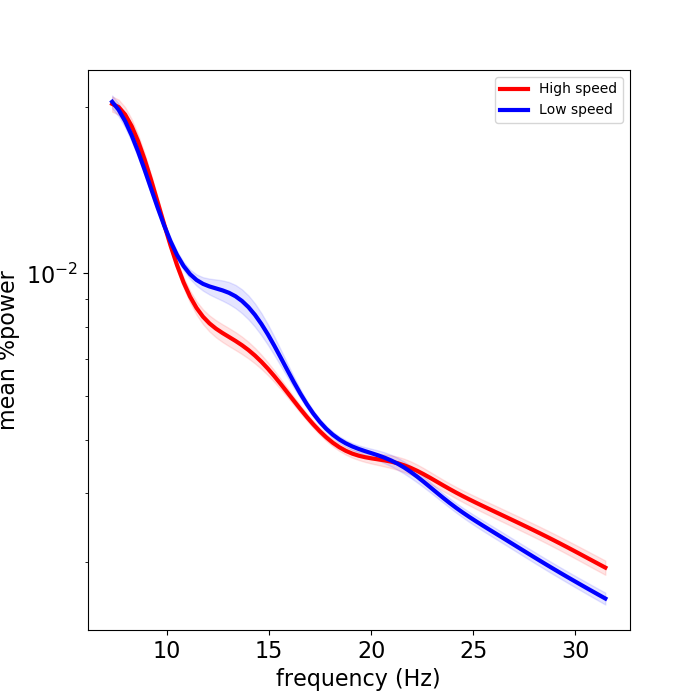

In [57]:
fig, ax = plt.subplots(1,1,figsize=(7, 7),gridspec_kw = {'top':0.9,'bottom':0.1,'wspace':0.1}
                      )
cutoff=100
ax.semilogy(f[23:cutoff], Mhigh[23:cutoff], linewidth=3,color='red', label='High speed')
ax.semilogy(f[23:cutoff], Mlow[23:cutoff], linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[23:cutoff], Mhigh[23:cutoff]-Stdhigh[23:cutoff], Mhigh[23:cutoff]+Stdhigh[23:cutoff],color='red',alpha=0.1)
ax.fill_between(f[23:cutoff], Mlow[23:cutoff]-Stdlow[23:cutoff], Mlow[23:cutoff]+Stdlow[23:cutoff],color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

In [7]:
dataPost = getData(dataFile,['lfp','mvmt'],period ='Post',drug=b'Amphetamin' ,day = lambda x: int(x)>3)
dataPre = getData(dataFile,['lfp','mvmt'],period ='Post',drug=b'Amphetamin' ,day = lambda x: int(x)==0)

cleaning up lfp data
I deleted session: 7584_day30A
I deleted session: 7909_day15A
I deleted session: 7909_day30A
cleaning up mvmt data
cleaning up lfp data
I deleted session: 4539_BaselineA
cleaning up mvmt data


<IPython.core.display.Javascript object>


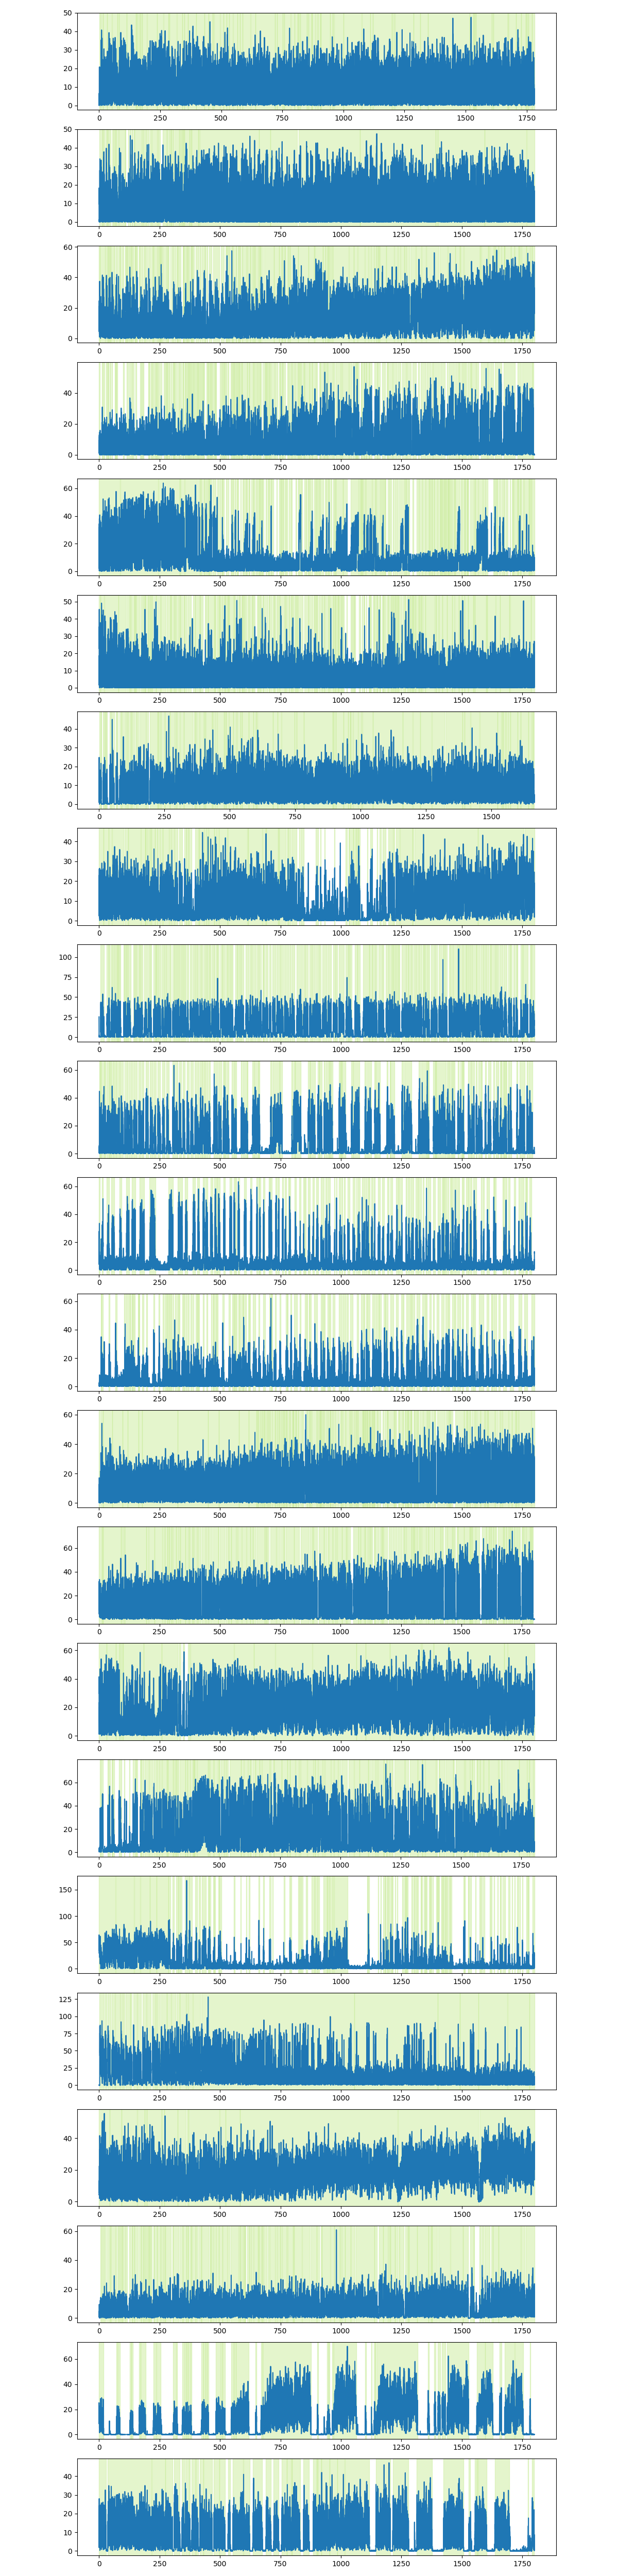

In [9]:
fig, ax = plt.subplots(len(dataPost.keys()),1,figsize=(12, 50),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})
Colors = CP('highLowSpeed')
dt = 1/20   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 2
dataPoints = int(np.ceil(Tseconds/dt))
th = 3
sessNum = 0
for s in dataPost.keys():
    #find movment onset:
    speed = dataPost[s]['mvmt']['speed']
    dt  = 1/dataPost[s]['mvmt']['Fs'][0]
    
    dataPost[s]['highSpeed'] = HighSpeedPeriods(ax[sessNum],speed.T,dt,th, dataPoints, Colors['high'])
    sessNum = sessNum +1

<IPython.core.display.Javascript object>


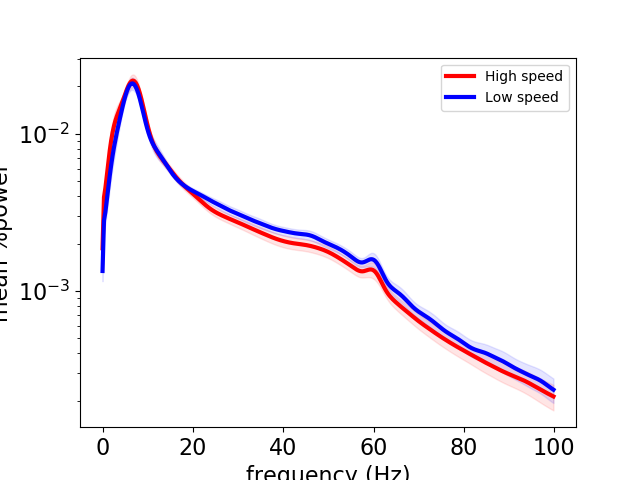

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


In [13]:
fig, ax = plt.subplots(1,1)
numS = len(dataPost.keys())
cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/dataPost['0761_day14A']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/dataPost['0761_day14A']['lfp']['FS'][0]

sNum = 0
phigh = []
plow = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in dataPost.keys():
    #find movment onset:
    speed = dataPost[s]['mvmt']['speed'].T
    lfp = dataPost[s]['lfp']['lfp'].T[0,:]
    if len(speed)<600:
        numS = numS-1
        continue
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(dataPost[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[dataPost[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[dataPost[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phigh.append(Power/totPower)    
    phigh.append(PowerHigh/totPowerHigh)
    plow.append(PowerLow/totPoweLow)
phigh = np.array(phigh)
plow = np.array(plow)
Mhigh = np.nanmean(phigh,axis=0)
Mlow = np.nanmean(plow,axis=0)
Stdhigh = np.nanstd(phigh, axis = 0)/np.sqrt(numS)
Stdlow = np.nanstd(plow, axis = 0)/np.sqrt(numS)
ax.semilogy(f[0:cutoff], Mhigh, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], Mlow, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], Mhigh-Stdhigh, Mhigh+Stdhigh,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], Mlow-Stdlow, Mlow+Stdlow,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

<IPython.core.display.Javascript object>


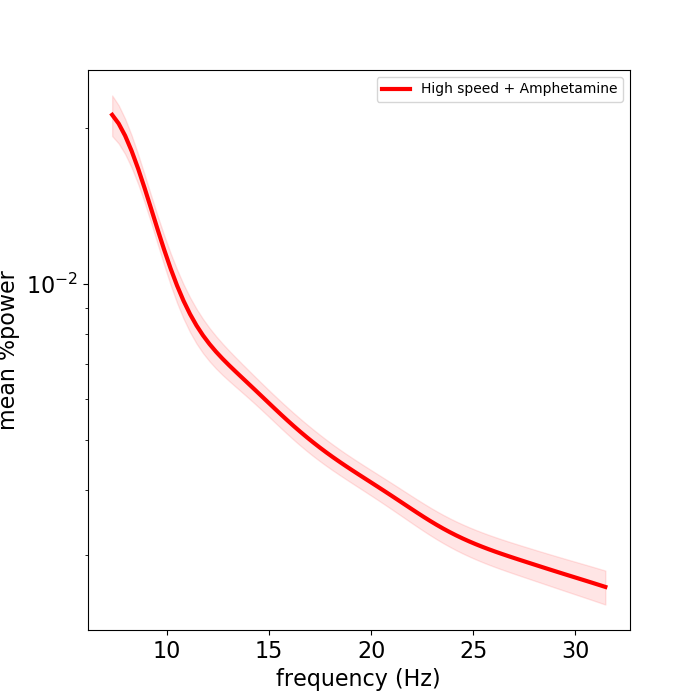

In [15]:
fig, ax = plt.subplots(1,1,figsize=(7, 7),gridspec_kw = {'top':0.9,'bottom':0.1,'wspace':0.1}
                      )
cutoff=100
ax.semilogy(f[23:cutoff], Mhigh[23:cutoff], linewidth=3,color='red', label='High speed + Amphetamine')
#ax.semilogy(f[23:cutoff], Mlow[23:cutoff], linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[23:cutoff], Mhigh[23:cutoff]-Stdhigh[23:cutoff], Mhigh[23:cutoff]+Stdhigh[23:cutoff],color='red',alpha=0.1)
#ax.fill_between(f[23:cutoff], Mlow[23:cutoff]-Stdlow[23:cutoff], Mlow[23:cutoff]+Stdlow[23:cutoff],color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()


<IPython.core.display.Javascript object>


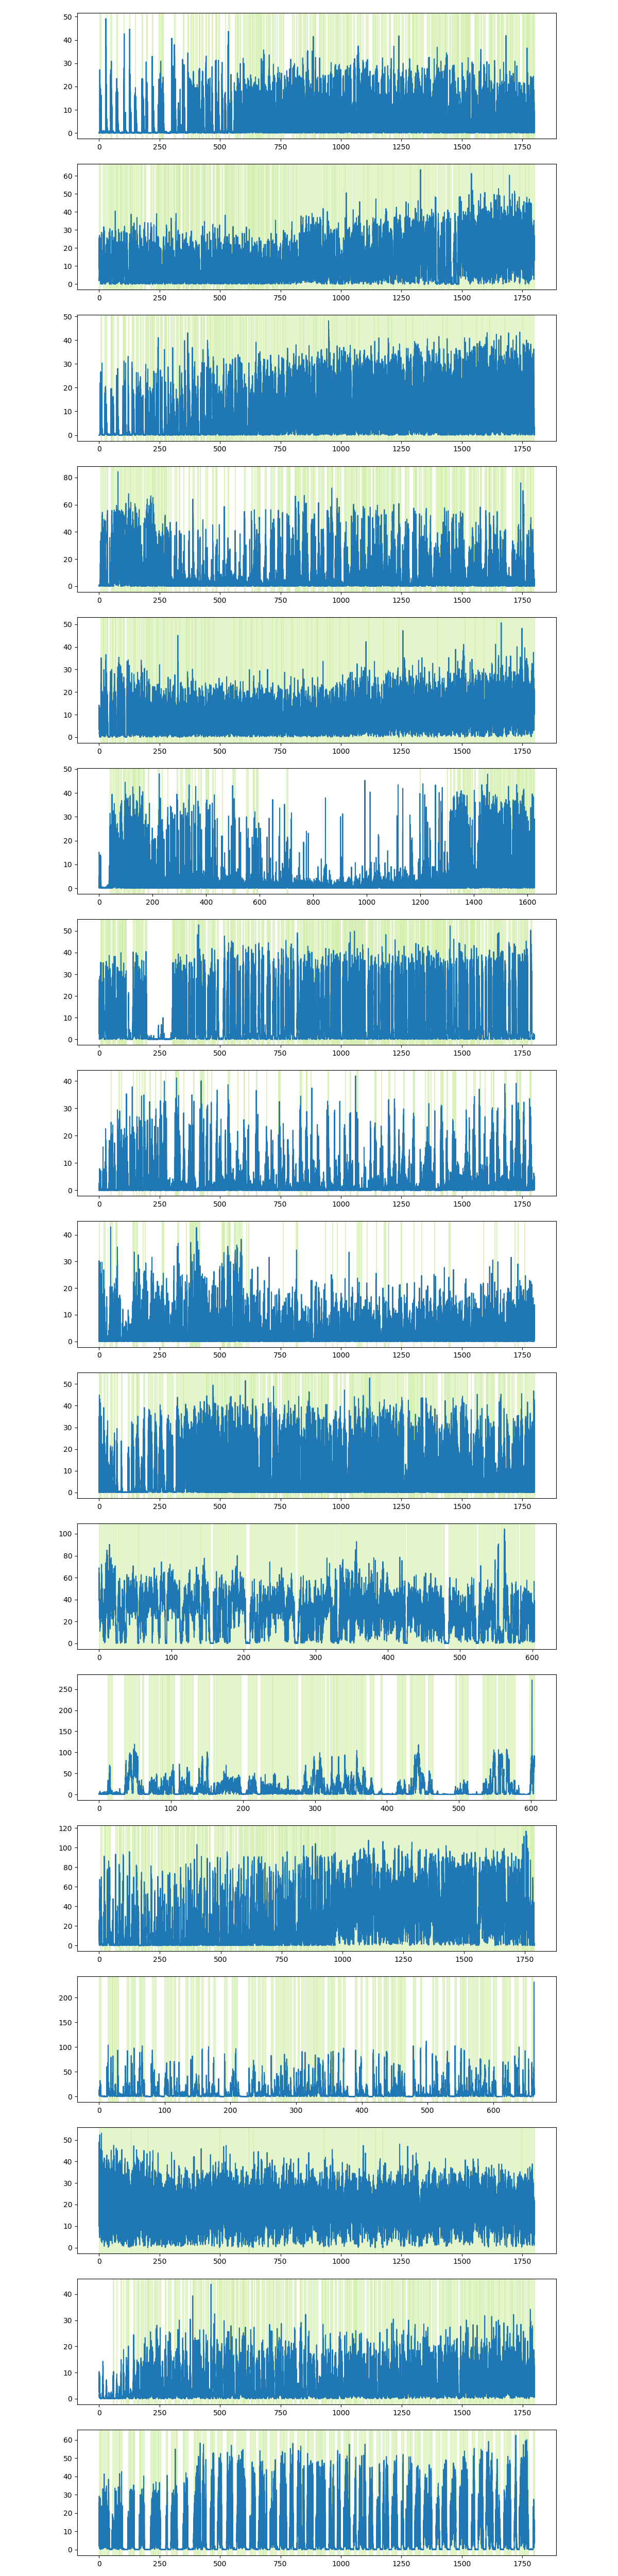

In [17]:
fig, ax = plt.subplots(len(dataPre.keys()),1,figsize=(12, 50),gridspec_kw = {'top':0.995,'bottom':0.008,'wspace':0.3})
Colors = CP('highLowSpeed')
dt = 1/20   # random session, assuming all session have the same dt...
#tPlot = np.linspace(-40*dt,40*dt,80)
Tseconds = 2
dataPoints = int(np.ceil(Tseconds/dt))
th = 3
sessNum = 0
for s in dataPre.keys():
    #find movment onset:
    speed = dataPre[s]['mvmt']['speed']
    dt  = 1/dataPre[s]['mvmt']['Fs'][0]
    
    dataPre[s]['highSpeed'] = HighSpeedPeriods(ax[sessNum],speed.T,dt,th, dataPoints, Colors['high'])
    sessNum = sessNum +1

In [22]:
fig, ax = plt.subplots(1,1)
numS = len(dataPre.keys())
cutoff = 315 # -> don't plot above this frequency...
dt_speed = 1/dataPre['0761_BaselineA']['mvmt']['Fs'][0]   # random session, assuming all session have the same dt...
tPlot = np.linspace(-40*dt_speed,40*dt_speed,80)
dt_lfp = 1/dataPre['0761_BaselineA']['lfp']['FS'][0]

sNum = 0
phighpre = []
plowPre = []
#aligned = np.empty((tPlot.size,cutoff,0))
for s in dataPre.keys():
    #find movment onset:
    speed = dataPre[s]['mvmt']['speed'].T
    lfp = dataPre[s]['lfp']['lfp'].T[0,:]
    if len(speed)<600:
        numS = numS-1
        continue
    #sOnset = FindMvmtOnset(speed,th =5,hi = 15)   
    # plot spectogram vs. speed onset:
    t_speed = np.linspace(0,len(speed)*dt_speed,len(speed))
    t_lfp = np.linspace(0,lfp.size*dt_lfp,lfp.size)
    
    f, t, Sxx = signal.spectrogram(lfp, 1/dt_lfp,window=('hamming'),nperseg=140,noverlap =120,nfft=1200)
    try:
        sxx = interpolate.interp1d(t,Sxx,fill_value='extrapolate')
    except:
        print(s, ' something went wrong')
        continue
    
    dSpec = sxx(t_lfp) 
    tLow = np.ones(t_lfp.shape,dtype=bool)
    thigh = np.zeros(t_lfp.shape, dtype=bool)
    #al = alignToOnset(dSpec[0,0:cutoff,:].transpose(), sOnset, winPost =40, winPre = 40)
    al = np.empty((1,cutoff))
    for l in range(0, len(dataPre[s]['highSpeed']['highSpeed']['start'])):
        ts = t_speed[dataPre[s]['highSpeed']['highSpeed']['start'][l]]
        te =t_speed[dataPre[s]['highSpeed']['highSpeed']['end'][l]]
        ind =  [i for (i, val) in enumerate(t_lfp) if (val>ts and val<te)]
        tLow[ind] = False
        thigh[ind] = True
    
    PowerHigh = np.sum(dSpec[0:cutoff,thigh],axis=1)
    PowerLow = np.sum(dSpec[0:cutoff,tLow],axis=1)
    totPowerHigh = np.sum(PowerHigh)
    totPoweLow = np.sum(PowerLow)
    
#    phighpre.append(Power/totPower)    
    phighpre.append(PowerHigh/totPowerHigh)
    plowPre.append(PowerLow/totPoweLow)
phighpre = np.array(phighpre)
plowPre = np.array(plowPre)
MhighPre = np.nanmean(phighpre,axis=0)
MlowPre = np.nanmean(plowPre,axis=0)
StdPrehigh = np.nanStd(phighpre, axis = 0)/np.sqrt(numS)
StdPrelow = np.nanStd(plowPre, axis = 0)/np.sqrt(numS)
ax.semilogy(f[0:cutoff], MhighPre, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], MlowPre, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], MhighPre-StdPrehigh, MhighPre+StdPrehigh,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], MlowPre-StdPrelow, MlowPre+StdPrelow,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

<IPython.core.display.Javascript object>

/home/dana_z/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)
/home/dana_z/anaconda3/lib/python3.7/site-packages/scipy/signal/spectral.py:1773: UserWarning: nperseg = 140 is greater than input length  = 0, using nperseg = 0
  .format(nperseg, input_length))


4539_Baseline2A  something went wrong


AttributeError: module 'numpy' has no attribute 'nanStdPre'

<IPython.core.display.Javascript object>


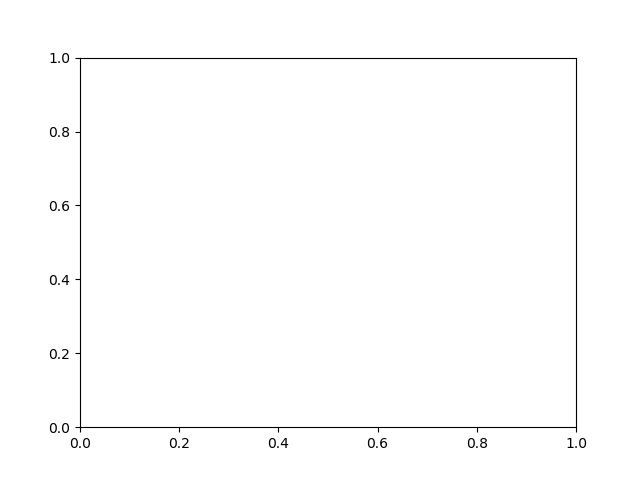

AttributeError: module 'numpy' has no attribute 'nanStd'

In [23]:
fig, ax = plt.subplots(1,1)
StdPrehigh = np.nanStd(phighpre, axis = 0)/np.sqrt(numS)
StdPrelow = np.nanStd(plowPre, axis = 0)/np.sqrt(numS)
ax.semilogy(f[0:cutoff], MhighPre, linewidth=3,color='red', label='High speed')
ax.semilogy(f[0:cutoff], MlowPre, linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[0:cutoff], MhighPre-StdPrehigh, MhighPre+StdPrehigh,color='red',alpha=0.1)
ax.fill_between(f[0:cutoff], MlowPre-StdPrelow, MlowPre+StdPrelow,color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()

In [19]:
fig, ax = plt.subplots(1,1,figsize=(7, 7),gridspec_kw = {'top':0.9,'bottom':0.1,'wspace':0.1}
                      )
cutoff=100
ax.semilogy(f[23:cutoff], MhighPre[23:cutoff], linewidth=3,color='red', label='High speed + Amphetamine')
#ax.semilogy(f[23:cutoff], Mlow[23:cutoff], linewidth=3,color='blue', label='Low speed')
ax.fill_between(f[23:cutoff], MhighPre[23:cutoff]-StdPrehigh[23:cutoff], MhighPre[23:cutoff]+StdPrehigh[23:cutoff],color='red',alpha=0.1)
#ax.fill_between(f[23:cutoff], Mlow[23:cutoff]-Stdlow[23:cutoff], Mlow[23:cutoff]+Stdlow[23:cutoff],color='blue',alpha=0.1)
ax.set_ylabel('mean %power',fontsize=16)
ax.set_xlabel('frequency (Hz)',fontsize=16)
ax.tick_params(labelsize=16)
ax.legend()


dict_keys(['0761_BaselineA', '1208_BaselineA', '1222_BaselineA', '1231_BaselineA', '1236_BaselineA', '1253_BaselineA', '1793_BaselineA', '2976_BaselineA', '2980_BaselineA', '2981_BaselineA', '4539_Baseline2A', '7584_BaselineA', '7909_Baseline2A', '7909_BaselineA', '8430_BaselineA', '8803_BaselineA', '8815_BaselineA'])